<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-04-23 21:46:19--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2019-04-23 21:46:19 (17.6 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [128]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [129]:
df.shape

(346, 10)

### Convert to date time object 

In [130]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [131]:
df['loan_status'].value_counts()

1    260
0     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [132]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
seaborn                   0.9.0                    py35_0    anaconda


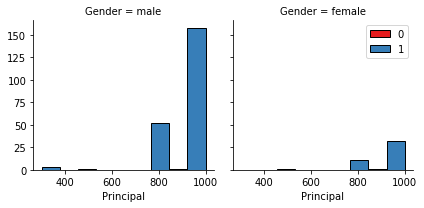

In [133]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

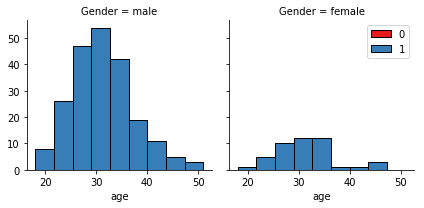

In [134]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

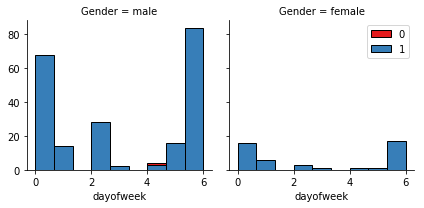

In [135]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [136]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [137]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  1              0.865385
        0              0.134615
male    1              0.731293
        0              0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [138]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [139]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              1              0.750000
                      0              0.250000
High School or Below  1              0.741722
                      0              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               1              0.765101
                      0              0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [140]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [141]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [142]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [143]:
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [144]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [145]:
# import the module to split the data into training and testing sets
from sklearn.model_selection import train_test_split
# split the data using 20% as test
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=4)
# imort sklearn's KNN classifier
from sklearn.neighbors import KNeighborsClassifier
# set initial k value
k=4
# train the classifier
neighbors=KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
# predict the Y values for the test set
yhat = neighbors.predict(X_test)
# print first 5 values
yhat[0:5]

array([1, 0, 1, 1, 1])

In [146]:
# import the metrics module
from sklearn import metrics
# show train set accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neighbors.predict(X_train)))
# show test set accuracy
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.815217391304
Test set Accuracy:  0.685714285714


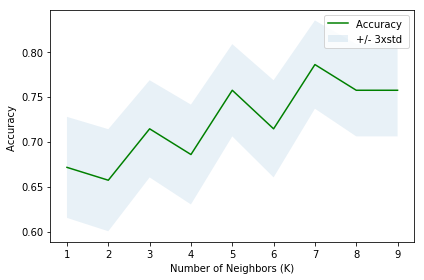

In [147]:
# iterate K from 1 to 10 and calculate the accuracy for each value of K
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    #Train Model and Predict  
    neighbors = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neighbors.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
# plot if on a graph to find the most accurate
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

from the graph 7 is obviously the best value for K

# Decision Tree

In [148]:
# import Decision tree classifier
from sklearn.tree import DecisionTreeClassifier
# initiate the classifier with "entropy" criteria and max depth 4
tree=DecisionTreeClassifier(criterion="entropy", max_depth=4)
# train the model
tree.fit(X_train, y_train)
# predict using the test set
predictedTree=tree.predict(X_test)

In [149]:
# print out the first 5 values
print(predictedTree[0:5])
print(y_test[0:5])

[0 0 1 1 1]
[1 1 1 1 1]


In [150]:
print("DecisionTree's Accuracy:", metrics.accuracy_score(y_test, predictedTree))

DecisionTree's Accuracy: 0.614285714286


# Support Vector Machine

In [151]:
# import support vector machine library
from sklearn import svm
# function to calculate the accuracy of each kernel
def evlauate_on_test_data(model=None):
    predictions= model.predict(X_test)
    correct_classifications = 0
    for i in range (len(y_test)):
        if predictions[i]==y_test[i]:
            correct_classifications += 1
    accuracy =100*correct_classifications/len(y_test)
    return accuracy


kernels=('linear', 'poly', 'rbf')
accuracies=[]
for index, kernel in enumerate(kernels):
    model=svm.SVC(kernel=kernel)
    model.fit(X_train, y_train)
    acc=evlauate_on_test_data(model)
    accuracies.append(acc)
    print("{} %accuracy obtained with kernel={}".format(acc, kernel))

78.57142857142857 %accuracy obtained with kernel=linear
77.14285714285714 %accuracy obtained with kernel=poly
74.28571428571429 %accuracy obtained with kernel=rbf


In [152]:
clf=svm.SVC(kernel="linear")
clf.fit(X_train, y_train)
yhat=clf.predict(X_test)
print("SVM Accuracy:", metrics.accuracy_score(y_test,yhat ))

SVM Accuracy: 0.785714285714


# Logistic Regression

In [153]:
# import logistic regression library
from sklearn.linear_model import LogisticRegression
# initialize and train the model
LR = LogisticRegression (C=0.01, solver='liblinear').fit(X_train, y_train)
# predict using the test set
yhat=LR.predict(X_test)
# get the probability estimates
yhat_prob=LR.predict_proba(X_test)

In [154]:
# import jaccard similarity score library
from sklearn.metrics import jaccard_similarity_score
# calculate and print jaccard similarity score
print("Logisitic Regression Score:", jaccard_similarity_score(y_test, yhat))

Logisitic Regression Score: 0.685714285714


In [155]:
# import the logistic loss library
from sklearn.metrics import log_loss
# calculate the logistic loss
log_loss(y_test, yhat_prob)

0.57722876094796538

# Model Evaluation using Test set

In [156]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [32]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-04-23 22:02:13--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-04-23 22:02:14 (678 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [177]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [178]:
# transform the dates to date objects
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
# get the day of the week from the date
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
# pick weekends
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
# group by gender
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
# convert male to 0 female to 1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
# group by education
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
# Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame
Feature2 = test_df[['Principal','terms','age','Gender','weekend']]
Feature2 = pd.concat([Feature2,pd.get_dummies(test_df['education'])], axis=1)
Feature2.drop(['Master or Above'], axis = 1,inplace=True)
# set X as features
X = Feature2
# set Y as the loan_status
y = test_df['loan_status'].values
# data standarization
X= preprocessing.StandardScaler().fit(X).transform(X)
# X.shape
# create report matrix to store the data
x = [['KNN', 0, 0, 'NA'],
          ['Decision Tree', 0, 0, 'NA'],
          ['SVM', 0, 0, 'NA'],
          ['LR', 0, 0, 'NA']
         ]
report = pd.DataFrame(x, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss']).set_index('Algorithm')

In [179]:
# predict using KNN with k set to 7
k=7
# train the classifier
# neighbors=KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
# predict the Y values for the test set
yhat_knn = neighbors.predict(X)
# calculate Jaccard score and add it to the report
report.loc['KNN','Jaccard'] = jaccard_similarity_score(y, yhat_knn)
# calculate F1 score and add it to the report
report.loc['KNN','F1-score'] = f1_score(y, yhat_knn)
report

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.685185,0.804598,NA
Decision Tree,0.000000,0.000000,NA
SVM,0.000000,0.000000,NA
LR,0.000000,0.000000,NA


In [180]:
# predict using the test set
y_predT=tree.predict(X)
# calculate Jaccard score and add it to the report
report.loc['Decision Tree','Jaccard'] = jaccard_similarity_score(y, y_predT)
# calculate F1 score and add it to the report
report.loc['Decision Tree','F1-score'] = f1_score(y, y_predT)
report

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.685185,0.804598,NA
Decision Tree,0.518519,0.566667,NA
SVM,0.000000,0.000000,NA
LR,0.000000,0.000000,NA


In [181]:
# predict using SVM
yhat_svm=clf.predict(X)
# calculate Jaccard score and add it to the report
report.loc['SVM','Jaccard'] = jaccard_similarity_score(y, yhat_svm)
# calculate F1 score and add it to the report
report.loc['SVM','F1-score'] = f1_score(y, yhat_svm)
report

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.685185,0.804598,NA
Decision Tree,0.518519,0.566667,NA
SVM,0.740741,0.851064,NA
LR,0.000000,0.000000,NA


In [182]:
yhat_lr=LR.predict(X)
yhat_prob=LR.predict_proba(X)
# calculate Jaccard score and add it to the report
report.loc['LR','Jaccard'] = jaccard_similarity_score(y, yhat_lr)
# calculate F1 score and add it to the report
report.loc['LR','F1-score'] = f1_score(y, yhat_lr)
# calculate LogLoss score and add it to the report
report.loc['LR', 'LogLoss'] = log_loss(y, yhat_prob)
report

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.685185,0.804598,NA
Decision Tree,0.518519,0.566667,NA
SVM,0.740741,0.851064,NA
LR,0.740741,0.851064,0.603787


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>